In [3]:
import os
import yaml
import requests
import zipfile
import glob
import shutil
import rasterio
import numpy as np
import geopandas as gpd
import pandas as pd
from osgeo import gdal, ogr, osr
from pathlib import Path
from rasterio.windows import from_bounds
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import fiona
import geopandas as gpd
from bmi_topography import Topography
from landlab.io import esri_ascii, write_esri_ascii
import matplotlib as mpl
import matplotlib.pyplot as plt
from landlab import imshowhs_grid, imshow_grid, imshow_grid_at_node
from matplotlib.colors import ListedColormap
import time

In [4]:
# ---- Config-driven inputs ----
config_path = "/home/abdullah/fire-debrisflow-ml/config/base.yaml" 
with open(config_path, "r") as f:
    cfg = yaml.safe_load(f)

clip_shapefile = cfg["aoi"]["aoi"]
target_resolution = cfg["raster"]["target_res"]
output_dir = cfg["paths"]["output_dir"]
os.makedirs(output_dir, exist_ok=True)

fire_name = cfg["fire"]["name"]
fire_id = cfg["fire"]["id"]

dem_cfg = cfg.get("dem", {})

In [5]:
# Load shapefile
gdf = gpd.read_file(clip_shapefile)

# Run a check to ensure shapefile is in UTM projection
if "UTM zone" in gdf.crs.to_wkt():
    # Already in UTM - just store EPSG code
    epsg_code = gdf.crs.to_epsg()
    crs = f"EPSG:{epsg_code}"
    print(f"Shapefile already in UTM: {crs}")
else:
    # If shapefile not in UTM projection
    # Convert to WGS84 first to get centroid in lon/lat
    centroid = gdf.to_crs(epsg=4326).geometry.unary_union.centroid
    zone = int((centroid.x + 180) / 6) + 1
    crs = f"EPSG:326{zone}"

    # Reproject and overwrite the shapefile
    gdf = gdf.to_crs(crs)
    gdf.to_file(clip_shapefile, driver="ESRI Shapefile")

print("CRS:", crs)

Shapefile already in UTM: EPSG:32613
CRS: EPSG:32613


In [6]:
# ---- Download USGS ~10m DEM using bmi-topography package ----
bounds = gpd.read_file(clip_shapefile).to_crs(epsg=4326).total_bounds
west, south, east, north = bounds
b = dem_cfg.get("buffer_deg", 0.05)

topo = Topography(
    dem_type=dem_cfg.get("dem_type", "USGS10m"),
    south=south - b,
    north=north + b,
    west=west - b,
    east=east + b,
    output_format=dem_cfg.get("output_format", "GTiff"),
    cache_dir=dem_cfg.get("cache_dir", output_dir),
    api_key=dem_cfg.get("api_key"),
)
fname = topo.fetch()

In [ ]:
Topography

In [7]:
# ---- Reproject raster ----
def reproject_raster_to_match_crs(src_path, target_crs_epsg, resampling_method, template_meta=None):
    resampling_dict = {
        'nearest': Resampling.nearest,
        'bilinear': Resampling.bilinear,
        'cubic': Resampling.cubic,
        'average': Resampling.average,
        'mode': Resampling.mode
    }
    resampling_enum = resampling_dict.get(resampling_method, Resampling.nearest)

    with rasterio.open(src_path) as src:
        dst_crs = f"EPSG:{target_crs_epsg}"
        if template_meta is None:
            transform, width, height = calculate_default_transform(
                src.crs, dst_crs, src.width, src.height, *src.bounds
            )
        else:
            # Snap to DEM grid
            transform = template_meta['transform']
            width = template_meta['width']
            height = template_meta['height']

        kwargs = src.meta.copy()
        kwargs.update({'crs': dst_crs, 'transform': transform, 'width': width, 'height': height})

        reprojected_path = src_path.replace('.tif', f'_reproj_{target_crs_epsg}.tif')
        with rasterio.open(reprojected_path, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=resampling_enum
                )
    return reprojected_path


# ---- Clip raster ----
def clip_raster_to_shape(raster_path, shapefile_path, template_meta=None):
    with fiona.open(shapefile_path, "r") as shapefile:
        shapes = [feature["geometry"] for feature in shapefile]

    with rasterio.open(raster_path) as src:
        out_image, out_transform = mask(src, shapes, crop=True)
        out_meta = src.meta.copy()

    if template_meta is not None:
        # Snap clipped raster to DEM grid exactly
        out_meta.update({
            "driver": "GTiff",
            "height": template_meta['height'],
            "width": template_meta['width'],
            "transform": template_meta['transform']
        })
    else:
        # For DEM (first raster)
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })

    clipped_path = raster_path.replace('.tif', '_clipped.tif')
    with rasterio.open(clipped_path, "w", **out_meta) as dest:
        dest.write(out_image)
    return clipped_path


# ---- Resample raster ----
def resample_raster(raster_path, template_meta=None, resampling_method='nearest', target_resolution=None):
    resampling_dict = {
        'nearest': Resampling.nearest,
        'bilinear': Resampling.bilinear,
        'cubic': Resampling.cubic,
        'average': Resampling.average,
        'mode': Resampling.mode
    }
    resampling_enum = resampling_dict.get(resampling_method, Resampling.nearest)

    with rasterio.open(raster_path) as src:
        kwargs = src.meta.copy()

        if template_meta is not None:
            # Snap resampled grid to DEM alignment
            transform = template_meta['transform']
            width = template_meta['width']
            height = template_meta['height']
        else:
            transform = src.transform
            width = src.width
            height = src.height
            if target_resolution is not None:
                scale_x = src.res[0] / target_resolution
                scale_y = src.res[1] / target_resolution
                width = int(src.width * scale_x)
                height = int(src.height * scale_y)
                transform = rasterio.Affine(
                    target_resolution, transform.b, transform.c,
                    transform.d, -target_resolution, transform.f
                )

        kwargs.update({'transform': transform, 'width': width, 'height': height})

        resampled_path = raster_path.replace('.tif', f'_resampled.tif')
        with rasterio.open(resampled_path, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=src.crs,
                    resampling=resampling_enum
                )
    return resampled_path


# ---- Convert to ASCII ----
def convert_to_ascii(tif_path, out_dir, template_meta=None):
    os.makedirs(out_dir, exist_ok=True)

    with rasterio.open(tif_path) as src:
        array = src.read(1)
        meta = template_meta if template_meta is not None else src.meta

        transform = meta['transform']
        width = meta['width']
        height = meta['height']

        xllcorner = transform[2]
        yllcorner = transform[5] + transform[4] * (height - 1) if transform[4] < 0 else transform[5] - transform[4] * (height - 1)
        cellsize = abs(transform[0])

        nodata_value = src.nodata if src.nodata is not None else -9999.0

        ascii_path = os.path.join(out_dir, os.path.basename(tif_path).replace('.tif', '.asc'))
        with open(ascii_path, 'w') as f:
            f.write(f"ncols         {width}\n")
            f.write(f"nrows         {height}\n")
            f.write(f"xllcorner     {xllcorner}\n")
            f.write(f"yllcorner     {yllcorner}\n")
            f.write(f"cellsize      {cellsize}\n")
            f.write(f"NODATA_value  {nodata_value}\n")
            for row in array:
                row_out = [str(nodata_value) if np.isnan(v) else str(v) for v in row]
                f.write(" ".join(row_out) + "\n")
    return ascii_path

In [ ]:
# import requests
# from pathlib import Path

# fire_name = 'Bolt Creek'
# fire_id = 'WA4772812134620220910' 

# fire_name_fmt = fire_name.lower().replace(" ", "_").replace("(", "").replace(")", "")
# fire_id_fmt = fire_id.lower()

# base_url = "https://edcintl.cr.usgs.gov/downloads/sciweb1/shared/MTBS_Fire/data/baer/"
# out_dir = Path("burn_severity")
# out_dir.mkdir(exist_ok=True)

# # Possible BAER/MTBS zip URLs
# candidates = [
#     f"{base_url}{fire_name_fmt}_sbs.zip",
#     f"{base_url}{fire_name_fmt}_{fire_id_fmt}_sbs.zip",
# ]

# for url in candidates:
#     r = requests.get(url, stream=True)
#     if r.status_code == 200:
#         out_path = out_dir / url.split("/")[-1]
#         with open(out_path, "wb") as f:
#             for chunk in r.iter_content(chunk_size=8192):
#                 f.write(chunk)
#         print(f"Downloaded: {out_path}")
#         break
# else:
#     raise RuntimeError("Burn severity zip not found for given fire.")


In [8]:
# ---- Build URL/resampling map from config ----
urls = {}

for name, info in cfg.get("feature_sources", {}).get("rasters", {}).items():
    url = info["url"]
    urls[url] = info.get("resampling", cfg["raster"]["resampling_method"])

for name, info in cfg.get("feature_sources", {}).get("landcover", {}).items():
    url = info["url"]
    urls[url] = info.get("resampling", "nearest")

bs = cfg.get("burn_severity", {})
src = bs.get("source", "local").lower()
if src == "local":
    local_path = os.path.join(bs["local"]["path"], bs["local"]["filename"])
    urls[local_path] = bs["local"].get("resampling", "nearest")
else:
    base_url = bs["remote"]["base_url"]
    fire_name_fmt = fire_name.lower().replace(" ", "_")
    fire_id_fmt = fire_id.lower()
    for pattern in bs["remote"]["candidates"]:
        url = pattern.format(
            base_url=base_url,
            fire_name_fmt=fire_name_fmt,
            fire_id_fmt=fire_id_fmt,
        )
        urls[url] = bs["remote"].get("resampling", "nearest")


In [9]:
# List for storing output file names ----
ascii_files = []

# ---- Process DEM ----
dem_reproj = reproject_raster_to_match_crs(str(fname), target_crs_epsg=crs.split(':')[1], resampling_method='cubic')
dem_clipped = clip_raster_to_shape(dem_reproj, clip_shapefile)
dem_resampled = resample_raster(dem_clipped, template_meta=None, resampling_method='cubic', target_resolution=target_resolution)
dem_ascii = convert_to_ascii(dem_resampled, output_dir, template_meta=None)

with rasterio.open(dem_resampled) as src:
    template_meta = src.meta.copy()  # lock DEM grid as template

# ---- Storing ASCII file names as we create them into a list so adding them to the model grid later requires no effort from the user ----
ascii_files.append(dem_ascii)

# ---- Process other rasters ----
for url, method in urls.items():
    local_path = None

    # Handle ZIP input
    if url.lower().endswith(".zip"):
        zip_filename = os.path.join(output_dir, os.path.basename(url))
        extract_dir = os.path.join(output_dir, "unzipped")

        for attempt in range(5):
            try:
                mode, downloaded = ('ab', os.path.getsize(zip_filename)) if os.path.exists(zip_filename) else ('wb', 0)
                headers = {"Range": f"bytes={downloaded}-"} if downloaded else {}

                with requests.get(url, headers=headers, stream=True, timeout=60) as r:
                    r.raise_for_status()
                    total_size = int(r.headers.get("Content-Length", 0)) + downloaded
                    with open(zip_filename, mode) as f:
                        for chunk in r.iter_content(chunk_size=1024 * 1024 * 50):
                            if chunk:
                                f.write(chunk)
                                downloaded += len(chunk)
                if downloaded >= total_size:
                    break
            except Exception:
                time.sleep(5)
        else:
            print(f"Failed to download {url}")
            continue

        if not os.path.exists(extract_dir):
            with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
                zip_ref.extractall(extract_dir)

        tif_files = [os.path.join(root, f)
                     for root, _, files in os.walk(extract_dir)
                     for f in files if f.lower().endswith(".tif")]
        if not tif_files:
            continue
        local_path = tif_files[0]

    # Handle TIFF input
    elif url.lower().endswith(".tif"):
        if url.startswith("http"):
            local_path = os.path.join(output_dir, os.path.basename(url))
            os.makedirs(output_dir, exist_ok=True)
            if not os.path.exists(local_path):
                try:
                    r = requests.get(url, stream=True, timeout=60)
                    r.raise_for_status()
                    with open(local_path, 'wb') as f:
                        for chunk in r.iter_content(chunk_size=1024 * 1024):
                            f.write(chunk)
                except Exception as e:
                    print(f"Download failed for {url}: {e}")
                    continue
        else:
            local_path = url
    else:
        print(f"Check file type: {url}")
        continue

    # ---- Process and snap to DEM grid ----
    try:
        reprojected = reproject_raster_to_match_crs(local_path, target_crs_epsg=crs.split(':')[1], resampling_method=method, template_meta=template_meta)
        resampled = resample_raster(reprojected, template_meta=template_meta, resampling_method=method, target_resolution=target_resolution)
        clipped = clip_raster_to_shape(resampled, clip_shapefile, template_meta=template_meta)
        ascii_file = convert_to_ascii(clipped, output_dir, template_meta=template_meta)
        ascii_files.append(ascii_file)
    except Exception as e:
        print(f"Failed processing {local_path}: {e}")
        continue

    # ---- Remove intermediate files ----
    for item in os.listdir(output_dir):
        item_path = os.path.join(output_dir, item)
        try:
            if os.path.isfile(item_path) and item_path.lower().endswith(('.tif', '.zip')):
                os.remove(item_path)
            elif os.path.isdir(item_path):
                shutil.rmtree(item_path)
        except Exception as e:
            print(f"Could not delete {item_path}: {e}")

Could not delete /mnt/c/Users/amehedi/Downloads/ml_debris/output/dem_diff.tif: [Errno 13] Permission denied: '/mnt/c/Users/amehedi/Downloads/ml_debris/output/dem_diff.tif'
Could not delete /mnt/c/Users/amehedi/Downloads/ml_debris/output/dem_diff.tif: [Errno 13] Permission denied: '/mnt/c/Users/amehedi/Downloads/ml_debris/output/dem_diff.tif'
Could not delete /mnt/c/Users/amehedi/Downloads/ml_debris/output/dem_diff.tif: [Errno 13] Permission denied: '/mnt/c/Users/amehedi/Downloads/ml_debris/output/dem_diff.tif'
Could not delete /mnt/c/Users/amehedi/Downloads/ml_debris/output/dem_diff.tif: [Errno 13] Permission denied: '/mnt/c/Users/amehedi/Downloads/ml_debris/output/dem_diff.tif'
Could not delete /mnt/c/Users/amehedi/Downloads/ml_debris/output/dem_diff.tif: [Errno 13] Permission denied: '/mnt/c/Users/amehedi/Downloads/ml_debris/output/dem_diff.tif'
Could not delete /mnt/c/Users/amehedi/Downloads/ml_debris/output/dem_diff.tif: [Errno 13] Permission denied: '/mnt/c/Users/amehedi/Downloads

In [10]:
ascii_files

['/mnt/c/Users/amehedi/Downloads/ml_debris/output/USGS10m_39.526781261542745_-107.29825878057063_39.71001199679379_-107.07137292552265_reproj_32613_clipped_resampled.asc',
 '/mnt/c/Users/amehedi/Downloads/ml_debris/output/cec7_0_cm_p_reproj_32613_resampled_clipped.asc',
 '/mnt/c/Users/amehedi/Downloads/ml_debris/output/anylithicdpt_cm_p_reproj_32613_resampled_clipped.asc',
 '/mnt/c/Users/amehedi/Downloads/ml_debris/output/claytotal_0_cm_p_reproj_32613_resampled_clipped.asc',
 '/mnt/c/Users/amehedi/Downloads/ml_debris/output/ph1to1h2o_0_cm_p_reproj_32613_resampled_clipped.asc',
 '/mnt/c/Users/amehedi/Downloads/ml_debris/output/sandtotal_0_cm_p_reproj_32613_resampled_clipped.asc',
 '/mnt/c/Users/amehedi/Downloads/ml_debris/output/silttotal_0_cm_p_reproj_32613_resampled_clipped.asc',
 '/mnt/c/Users/amehedi/Downloads/ml_debris/output/dbovendry_0_cm_p_reproj_32613_resampled_clipped.asc',
 '/mnt/c/Users/amehedi/Downloads/ml_debris/output/Annual_NLCD_LndCov_2021_CU_C1V1_reproj_32613_resampled

In [9]:
import os
import numpy as np
from landlab.io import esri_ascii

# ascii_files = ['/mnt/c/Users/amehedi/Downloads/ml_debris/output/USGS10m_39.490181629903795_-107.34086314980591_39.71896678300246_-107.04663845742944_reproj_26913_clipped_resampled.asc',
#  '/mnt/c/Users/amehedi/Downloads/ml_debris/output/cec7_0_cm_p_reproj_26913_resampled_clipped.asc',
#  '/mnt/c/Users/amehedi/Downloads/ml_debris/output/anylithicdpt_cm_p_reproj_26913_resampled_clipped.asc',
#  '/mnt/c/Users/amehedi/Downloads/ml_debris/output/claytotal_0_cm_p_reproj_26913_resampled_clipped.asc',
#  '/mnt/c/Users/amehedi/Downloads/ml_debris/output/ph1to1h2o_0_cm_p_reproj_26913_resampled_clipped.asc',
#  '/mnt/c/Users/amehedi/Downloads/ml_debris/output/sandtotal_0_cm_p_reproj_26913_resampled_clipped.asc',
#  '/mnt/c/Users/amehedi/Downloads/ml_debris/output/silttotal_0_cm_p_reproj_26913_resampled_clipped.asc',
#  '/mnt/c/Users/amehedi/Downloads/ml_debris/output/dbovendry_0_cm_p_reproj_26913_resampled_clipped.asc',
#  '/mnt/c/Users/amehedi/Downloads/ml_debris/output/Annual_NLCD_LndCov_2021_CU_C1V1_reproj_26913_resampled_clipped.asc',
#  '/mnt/c/Users/amehedi/Downloads/ml_debris/output/pioneer_wa4818312053120240608_sbs_reproj_26913_resampled_clipped.asc']

def _read_nodata(ascii_path, default=-9999.0):
    nodata_val = None
    with open(ascii_path, "r") as f:
        for line in f:
            if line.strip().upper().startswith("NODATA_VALUE"):
                nodata_val = float(line.split()[1])
                break
    return default if nodata_val is None else nodata_val

def _load_vals(ascii_path, field_name):
    with open(ascii_path, "r") as f:
        g = esri_ascii.load(f, name=field_name)
    return g.at_node[field_name].copy()

# 0) DEM -> master grid
nodata = _read_nodata(ascii_files[0])
with open(ascii_files[0], "r") as f:
    grid = esri_ascii.load(f, name="topographic__elevation")
elev = grid.at_node["topographic__elevation"]
grid.set_nodata_nodes_to_closed(elev, nodata)

# 1) CEC (scale /10)
nodata = _read_nodata(ascii_files[1])
cec = _load_vals(ascii_files[1], "cation__exchange_capacity")
grid.add_field("cation__exchange_capacity", cec / 10, at="node", clobber=True)
grid.set_nodata_nodes_to_closed(cec, nodata)

# 2) Soil thickness (scale /100)
nodata = _read_nodata(ascii_files[2])
hs = _load_vals(ascii_files[2], "soil__thickness")
grid.add_field("soil__thickness", hs / 100, at="node", clobber=True)
grid.set_nodata_nodes_to_closed(hs, nodata)

# 3) Clay
nodata = _read_nodata(ascii_files[3])
cl = _load_vals(ascii_files[3], "clay__total")
grid.add_field("clay__total", cl, at="node", clobber=True)
grid.set_nodata_nodes_to_closed(cl, nodata)

# 4) pH (scale /100)
nodata = _read_nodata(ascii_files[4])
ph = _load_vals(ascii_files[4], "pH")
grid.add_field("pH", ph / 100, at="node", clobber=True)
grid.set_nodata_nodes_to_closed(ph, nodata)

# 5) Sand
nodata = _read_nodata(ascii_files[5])
sa = _load_vals(ascii_files[5], "sand__total")
grid.add_field("sand__total", sa, at="node", clobber=True)
grid.set_nodata_nodes_to_closed(sa, nodata)

# 6) Silt
nodata = _read_nodata(ascii_files[6])
si = _load_vals(ascii_files[6], "silt__total")
grid.add_field("silt__total", si, at="node", clobber=True)
grid.set_nodata_nodes_to_closed(si, nodata)

# 7) Dry bulk density (scale /100)
nodata = _read_nodata(ascii_files[7])
db = _load_vals(ascii_files[7], "dry__bulk_density")
grid.add_field("dry__bulk_density", db / 100, at="node", clobber=True)
grid.set_nodata_nodes_to_closed(db, nodata)

# 8) Landcover (close nodata + class 11)
nodata = _read_nodata(ascii_files[8])
lc = _load_vals(ascii_files[8], "landcover")
grid.add_field("landcover", lc, at="node", clobber=True)
grid.set_nodata_nodes_to_closed(lc, nodata)
grid.set_nodata_nodes_to_closed(lc, 11)

# 9) Burn severity (reclass)
nodata = _read_nodata(ascii_files[9])
bs = _load_vals(ascii_files[9], "burn__severity")
bs[~np.isin(bs, [2, 3, 4])] = 1
grid.add_field("burn__severity", bs, at="node", clobber=True)

grid

RasterModelGrid((922, 1092), xy_spacing=(np.float64(10.0), np.float64(10.0)), xy_of_lower_left=(np.float64(306982.93519811454), np.float64(4383083.264309347)))

In [12]:
import os
import sys
from pathlib import Path
import numpy as np
import yaml

repo_root = Path("/home/abdullah/fire-debrisflow-ml")
sys.path.insert(0, str(repo_root / "src"))

from landlab_io import load_grid, add_ascii_field, read_nodata_value, write_ascii_field
from soil_features import (
    compute_ksat,
    compute_transmissivity,
    compute_saturated_water_content,
    compute_soil_texture,
    compute_fc_wp_arrays,
    compute_soil_density,
)
from vegetation_features import rootcohesion, adjust_internal_friction_angle, compute_cohesion, vegtype

cfg = yaml.safe_load(open(repo_root / "config" / "base.yaml", "r"))
out_dir = Path(cfg["paths"]["output_dir"])

# Auto-detect DEM (original name or renamed)
dem_path = next(out_dir.glob("*USGS10m*_clipped_resampled.asc"), None)
if dem_path is None:
    dem_path = out_dir / "topographic__elevation.asc"

if not dem_path.exists():
    raise FileNotFoundError(f"DEM not found in {out_dir}")

def burn_reclass(vals):
    vals = np.asarray(vals).copy()
    vals[~np.isin(vals, [2, 3, 4])] = 1
    return vals

# Load DEM -> master grid
grid = load_grid(str(dem_path), "topographic__elevation")
nodata = read_nodata_value(str(dem_path))
grid.set_nodata_nodes_to_closed(grid.at_node["topographic__elevation"], nodata)

# Rename DEM if not already
dem_renamed = out_dir / "topographic__elevation.asc"
if dem_path != dem_renamed and dem_path.exists():
    os.rename(dem_path, dem_renamed)

# Source files (use renamed files if present, else original)
def pick_file(renamed, original_glob):
    renamed_path = out_dir / renamed
    if renamed_path.exists():
        return renamed_path
    found = next(out_dir.glob(original_glob), None)
    if found is None:
        raise FileNotFoundError(f"Missing {renamed} or {original_glob}")
    return found

sources = [
    (pick_file("cation__exchange_capacity.asc", "*cec7_0_cm*_clipped.asc"), "cation__exchange_capacity", dict(scale=0.1)),
    (pick_file("soil__thickness.asc", "*anylithicdpt_cm*_clipped.asc"), "soil__thickness", dict(scale=0.01)),
    (pick_file("clay__total.asc", "*claytotal_0_cm*_clipped.asc"), "clay__total", dict()),
    (pick_file("pH.asc", "*ph1to1h2o_0_cm*_clipped.asc"), "pH", dict(scale=0.01)),
    (pick_file("sand__total.asc", "*sandtotal_0_cm*_clipped.asc"), "sand__total", dict()),
    (pick_file("silt__total.asc", "*silttotal_0_cm*_clipped.asc"), "silt__total", dict()),
    (pick_file("dry__bulk_density.asc", "*dbovendry_0_cm*_clipped.asc"), "dry__bulk_density", dict(scale=0.01)),
    (pick_file("landcover.asc", "*NLCD*clipped.asc"), "landcover", dict(extra_close_values=[11])),
    (pick_file("burn__severity.asc", "*_sbs*_clipped.asc"), "burn__severity", dict(close_nodata=False, transform=burn_reclass)),
]

for path, field_name, kwargs in sources:
    add_ascii_field(grid, str(path), field_name, rename_file=True, **kwargs)

# Derived features + outputs
ksat = compute_ksat(
    grid.at_node["pH"],
    grid.at_node["clay__total"],
    grid.at_node["silt__total"],
    grid.at_node["cation__exchange_capacity"],
)
grid.add_field(
    "soil__saturated_hydraulic_conductivity",
    (ksat / 100) * 10,
    at="node",
    clobber=True,
)
write_ascii_field(str(out_dir / "soil__saturated_hydraulic_conductivity.asc"), grid, "soil__saturated_hydraulic_conductivity")

trans = compute_transmissivity(
    grid.at_node["soil__saturated_hydraulic_conductivity"],
    grid.at_node["soil__thickness"],
)
grid.add_field("soil__transmissivity", trans, at="node", clobber=True)
write_ascii_field(str(out_dir / "soil__transmissivity.asc"), grid, "soil__transmissivity")

wsat = compute_saturated_water_content(
    grid.at_node["dry__bulk_density"],
    grid.at_node["clay__total"],
    grid.at_node["silt__total"],
)
grid.add_field("saturated__water_content", wsat, at="node", clobber=True)
write_ascii_field(str(out_dir / "saturated__water_content.asc"), grid, "saturated__water_content")

soil_texture = compute_soil_texture(
    grid.at_node["sand__total"],
    grid.at_node["silt__total"],
    grid.at_node["clay__total"],
)
grid.add_field("soil__texture", soil_texture, at="node", clobber=True)
write_ascii_field(str(out_dir / "soil__texture.asc"), grid, "soil__texture")

porosity, theta_fc, theta_wp, phi = compute_fc_wp_arrays(
    grid.at_node["soil__texture"],
    grid.at_node["saturated__water_content"],
)
grid.add_field("field__capacity", theta_fc, at="node", clobber=True)
grid.add_field("wilting__point", theta_wp, at="node", clobber=True)
grid.add_field("porosity", porosity, at="node", clobber=True)
grid.add_field("soil__internal_friction_angle", phi, at="node", clobber=True)

if "landcover" in grid.at_node:
    grid.at_node["soil__internal_friction_angle"] = adjust_internal_friction_angle(
        grid.at_node["landcover"],
        grid.at_node["soil__internal_friction_angle"],
    )

write_ascii_field(str(out_dir / "field__capacity.asc"), grid, "field__capacity")
write_ascii_field(str(out_dir / "wilting__point.asc"), grid, "wilting__point")
write_ascii_field(str(out_dir / "porosity.asc"), grid, "porosity")
write_ascii_field(str(out_dir / "soil__internal_friction_angle.asc"), grid, "soil__internal_friction_angle")

density = compute_soil_density(grid.at_node["dry__bulk_density"], grid.at_node["porosity"])
grid.add_field("soil__density", density, at="node", clobber=True)
write_ascii_field(str(out_dir / "soil__density.asc"), grid, "soil__density")

if "landcover" in grid.at_node:
    landcover = grid.at_node["landcover"]
    grid.add_field("landcovercolor", rootcohesion(landcover, 0, 1, 2, 3, 4, 5), at="node", clobber=True)

    c_min, c_mode, c_max = compute_cohesion(landcover)
    grid.add_field("soil__minimum_total_cohesion", c_min, at="node", clobber=True)
    grid.add_field("soil__maximum_total_cohesion", c_max, at="node", clobber=True)
    grid.add_field("soil__mode_total_cohesion", c_mode, at="node", clobber=True)
    write_ascii_field(str(out_dir / "soil__minimum_total_cohesion.asc"), grid, "soil__minimum_total_cohesion")
    write_ascii_field(str(out_dir / "soil__maximum_total_cohesion.asc"), grid, "soil__maximum_total_cohesion")
    write_ascii_field(str(out_dir / "soil__mode_total_cohesion.asc"), grid, "soil__mode_total_cohesion")

    vegetation_type = vegtype(landcover, -9999.0, 3, 2, 1, 0)
    grid.add_field("vegetation__plant_functional_type", vegetation_type, at="node", clobber=True)
    write_ascii_field(str(out_dir / "vegetation__plant_functional_type.asc"), grid, "vegetation__plant_functional_type")

grid

/tmp/ipykernel_49753/513284724.py:85: DeprecationWarning: landlab.io.write_esri_ascii has been deprecated, use landlab.io.esri_ascii.dump instead
  write_ascii_field(str(out_dir / "soil__saturated_hydraulic_conductivity.asc"), grid, "soil__saturated_hydraulic_conductivity")
/tmp/ipykernel_49753/513284724.py:92: DeprecationWarning: landlab.io.write_esri_ascii has been deprecated, use landlab.io.esri_ascii.dump instead
  write_ascii_field(str(out_dir / "soil__transmissivity.asc"), grid, "soil__transmissivity")
/tmp/ipykernel_49753/513284724.py:100: DeprecationWarning: landlab.io.write_esri_ascii has been deprecated, use landlab.io.esri_ascii.dump instead
  write_ascii_field(str(out_dir / "saturated__water_content.asc"), grid, "saturated__water_content")
/tmp/ipykernel_49753/513284724.py:108: DeprecationWarning: landlab.io.write_esri_ascii has been deprecated, use landlab.io.esri_ascii.dump instead
  write_ascii_field(str(out_dir / "soil__texture.asc"), grid, "soil__texture")
/tmp/ipykern

RasterModelGrid((922, 1092), xy_spacing=(np.float64(10.0), np.float64(10.0)), xy_of_lower_left=(np.float64(306982.93519811454), np.float64(4383083.264309347)))

In [13]:
list(grid.at_node.keys())

['topographic__elevation',
 'cation__exchange_capacity',
 'soil__thickness',
 'clay__total',
 'pH',
 'sand__total',
 'silt__total',
 'dry__bulk_density',
 'landcover',
 'burn__severity',
 'soil__saturated_hydraulic_conductivity',
 'soil__transmissivity',
 'saturated__water_content',
 'soil__texture',
 'field__capacity',
 'wilting__point',
 'porosity',
 'soil__internal_friction_angle',
 'soil__density',
 'landcovercolor',
 'soil__minimum_total_cohesion',
 'soil__maximum_total_cohesion',
 'soil__mode_total_cohesion',
 'vegetation__plant_functional_type']

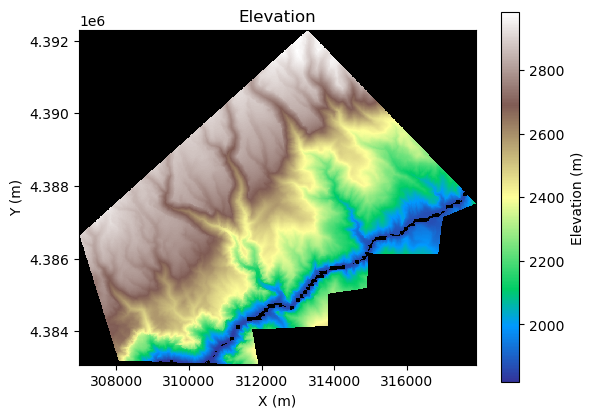

In [14]:
imshow_grid(grid,'topographic__elevation', plot_name = 'Elevation',
            var_name = 'Elevation', var_units = 'm', grid_units = ('m','m'),
            cmap = 'terrain')

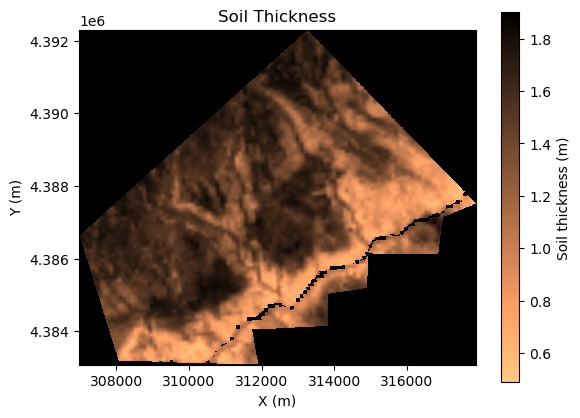

In [13]:
imshow_grid(grid,'soil__thickness', plot_name = 'Soil Thickness',
            var_name = 'Soil thickness', var_units = 'm', grid_units = ('m','m'),
            cmap = 'copper_r')

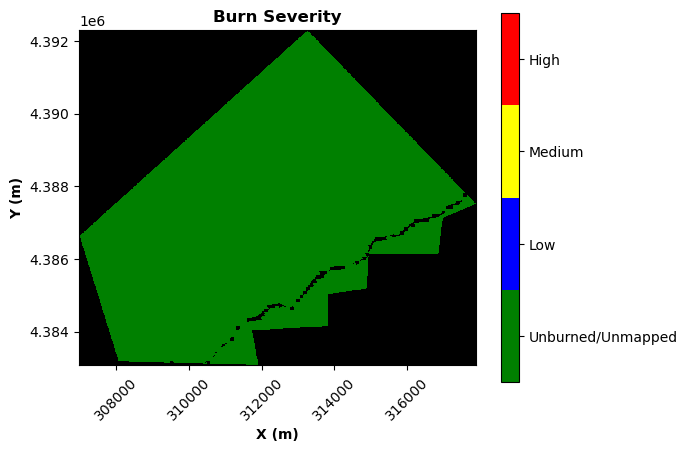

In [14]:
imshow_grid_at_node(grid, 'burn__severity', plot_name = 'Burn Severity',
            cmap = ListedColormap(['green',"blue", "yellow", "red"], N=4), limits = (0.5,4.5), allow_colorbar= False)
cb = plt.colorbar()
cb.set_ticks([1,2,3,4])
cb.set_ticklabels(['Unburned/Unmapped', 'Low','Medium','High'])
plt.title('Burn Severity', fontweight='bold')
plt.xlabel('X (m)', fontweight='bold')
plt.ylabel('Y (m)', fontweight='bold')
plt.xticks(rotation=45)
plt.show()

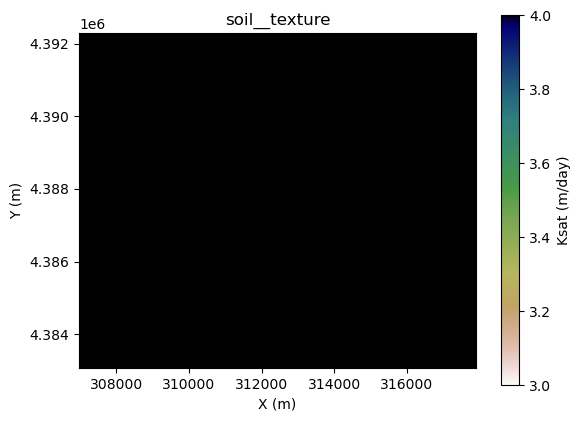

In [15]:
imshow_grid(grid,'soil__texture', plot_name = 'soil__texture',
            var_name = 'Ksat', var_units = 'm/day', grid_units = ('m','m'),
            cmap = 'gist_earth_r')

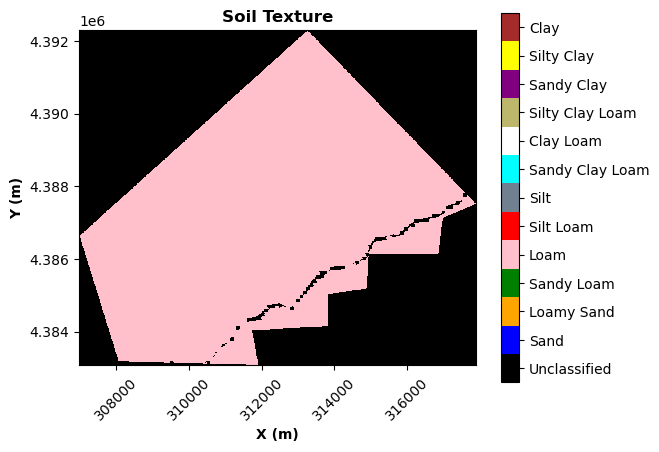

In [16]:
imshow_grid_at_node(grid, 'soil__texture', plot_name = 'Soil Texture',
            cmap = ListedColormap(['k',"blue", "orange", "green", "pink", "red",
                        "slategray", "cyan", "white", "darkkhaki", "purple", "yellow", 'brown'], N=13), limits = (-0.5,12.5), allow_colorbar= False)
cb = plt.colorbar()
cb.set_ticks([0,1,2,3,4,5,6,7,8,9, 10, 11, 12])
cb.set_ticklabels(['Unclassified', 'Sand','Loamy Sand','Sandy Loam','Loam','Silt Loam', 'Silt',
                  'Sandy Clay Loam','Clay Loam', 'Silty Clay Loam','Sandy Clay', 'Silty Clay', 'Clay'])
plt.title('Soil Texture', fontweight='bold')
plt.xlabel('X (m)', fontweight='bold')
plt.ylabel('Y (m)', fontweight='bold')
plt.xticks(rotation=45)
plt.show()

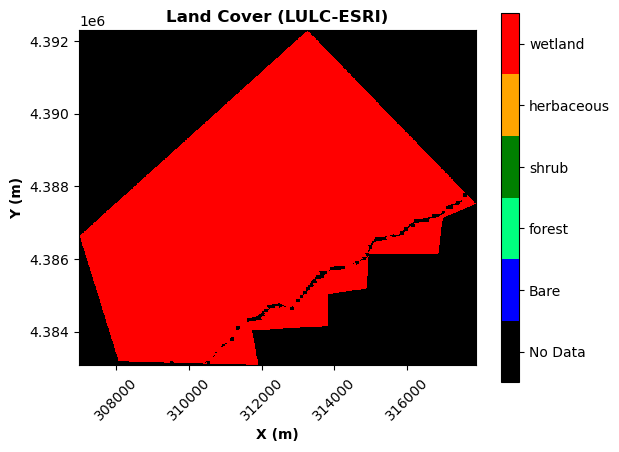

In [17]:
imshow_grid_at_node(grid, 'landcover', plot_name = 'Burmapinar Landcover Classifications',
            cmap = ListedColormap(['k',"blue", "springgreen", "green", "orange", "red",
                        "slategray", "cyan", "white", "darkkhaki"], N=6), limits = (-0.5,5.5), allow_colorbar= False)
cb = plt.colorbar()
cb.set_ticks([0,1,2,3,4,5])
cb.set_ticklabels(['No Data', 'Bare', 'forest', 'shrub', 'herbaceous', 'wetland'])
plt.title('Land Cover (LULC-ESRI)', fontweight='bold')
plt.xlabel('X (m)', fontweight='bold')
plt.ylabel('Y (m)', fontweight='bold')
plt.xticks(rotation=45)
plt.show()

In [18]:
from landlab.io import esri_ascii

lc_path = "/mnt/c/Users/amehedi/Downloads/ml_debris/output/landcover.asc"

with open(lc_path, "r") as f:
    grid = esri_ascii.load(f, name="landcover")

landcover = grid.at_node["landcover"]
landcover

array([250., 250., 250., ..., 250., 250., 250.], shape=(1006824,))

In [ ]:
np.unique(landcover[~np.isnan(landcover)])[:20]

array([ 11.,  21.,  22.,  23.,  24.,  41.,  42.,  43.,  52.,  71.,  81.,
        82.,  90., 250.])

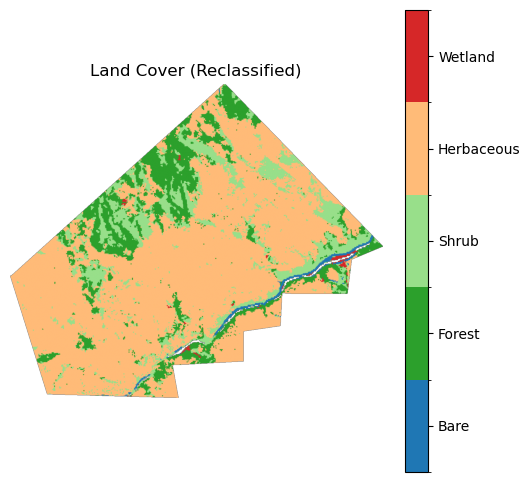

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

lc = landcover.copy()
lc = np.where(lc == 250, np.nan, lc)

lulc = np.full_like(lc, np.nan, dtype=float)
lulc[np.isin(lc, [12, 21, 22, 23, 24, 31])] = 1  # Bare/Developed
lulc[np.isin(lc, [41, 42, 43])] = 2              # Forest
lulc[np.isin(lc, [51, 52])] = 3                  # Shrub
lulc[np.isin(lc, [71, 72, 73, 74, 81, 82])] = 4  # Herbaceous
lulc[np.isin(lc, [90, 95])] = 5                  # Wetland

cmap = ListedColormap(["#1f77b4", "#2ca02c", "#98df8a", "#ffbb78", "#d62728"])
bounds = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5]
norm = BoundaryNorm(bounds, cmap.N)

plt.figure(figsize=(6, 6))
plt.imshow(lulc.reshape(grid.shape), cmap=cmap, norm=norm, origin="lower")
cb = plt.colorbar(ticks=[1, 2, 3, 4, 5])
cb.set_ticklabels(["Bare", "Forest", "Shrub", "Herbaceous", "Wetland"])
plt.title("Land Cover (Reclassified)")
plt.axis("off")
plt.show()

In [22]:
imshow_grid_at_node(grid,'soil__mode_total_cohesion', plot_name = 'Mode cohesion',
            var_name = 'Soil Cohesion', var_units = 'Pa', grid_units = ('m','m'),
            cmap = 'Greens')

FieldError: soil__mode_total_cohesion

In [23]:
imshow_grid_at_node(grid, 'vegetation__plant_functional_type', plot_name = 'Vegetation Type',
            cmap = ListedColormap(['pink',"darkkhaki", "springgreen", "red"], N=4), limits = (-0.5,3.5), allow_colorbar= False)
cb = plt.colorbar()
cb.set_ticks([0,1,2,3])
cb.set_ticklabels(['grass', 'shrub','tree','bare'])
plt.title('Vegetation Type', fontweight='bold')
plt.xlabel('X (m)', fontweight='bold')
plt.ylabel('Y (m)', fontweight='bold')
plt.xticks(rotation=45)
plt.show()

FieldError: vegetation__plant_functional_type

In [15]:
from pathlib import Path
from landlab.io import esri_ascii

out_dir = Path("/mnt/c/Users/amehedi/Downloads/ml_debris/output")

def load_vals(ascii_path, field_name=None):
    field_name = field_name or Path(ascii_path).stem
    with open(ascii_path, "r") as f:
        grid = esri_ascii.load(f, name=field_name)
    return grid, grid.at_node[field_name].copy()

# 1) Master grid from elevation
elev_path = out_dir / "topographic__elevation.asc"
grid, _ = load_vals(elev_path, "topographic__elevation")

# 2) Load all other fields into the same grid
for p in sorted(out_dir.glob("*.asc")):
    if p == elev_path:
        continue
    field = p.stem
    _, vals = load_vals(p, field)
    if vals.size != grid.number_of_nodes:
        raise ValueError(f"{p.name} has {vals.size} nodes, expected {grid.number_of_nodes}")
    grid.add_field(field, vals, at="node", clobber=True)

# Now everything is in memory
list(grid.at_node.keys())

vars_of_interest = [
    "topographic__elevation",
    "soil__thickness",
    "clay__total",
    "pH",
    "sand__total",
    "dem_diff"
]

# optional: nodata per variable (leave empty if not needed)
nodata_map = {
    # "pH": -9999.0,
}

# build dataframe
df = pd.DataFrame({v: grid.at_node[v] for v in vars_of_interest})

# drop closed/nodata nodes if grid has them
if hasattr(grid, "status_at_node"):
    df = df[grid.status_at_node != 4]  # 4 = closed in Landlab

# replace nodata values with NaN
for v, nd in nodata_map.items():
    df[v] = df[v].replace(nd, np.nan)

df = df.replace(-9999, np.nan)  # generic fallback
df = df.dropna()

# descriptive stats
desc_stats = df.describe().T
desc_stats

# correlation matrix
corr = df.corr()
corr

,topographic__elevation,soil__thickness,clay__total,pH,sand__total,dem_diff
topographic__elevation,1.000000,-0.122938,-0.373920,-0.375641,-0.373434,0.000347
soil__thickness,-0.122938,1.000000,0.397029,0.346751,0.244845,0.016667
clay__total,-0.373920,0.397029,1.000000,0.996971,0.979383,0.010182
pH,-0.375641,0.346751,0.996971,1.000000,0.991223,0.009899
sand__total,-0.373434,0.244845,0.979383,0.991223,1.000000,0.008681
dem_diff,0.000347,0.016667,0.010182,0.009899,0.008681,1.000000


In [26]:
import os
import yaml
import rasterio
import geopandas as gpd
import numpy as np
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.mask import mask
from landlab.io import esri_ascii
from pathlib import Path

# ----------------------------
# Config + paths
# ----------------------------
cfg = yaml.safe_load(open("/home/abdullah/fire-debrisflow-ml/config/base.yaml", "r"))

# AOI override (as requested)
clip_shapefile = "/mnt/c/Users/amehedi/Downloads/ml_debris/input/grizzly_sub_aoi.shp"

output_dir = cfg["paths"]["output_dir"]
target_resolution = cfg["raster"]["target_res"]

# DEM files from screenshot
dem_pre_src  = "/mnt/c/Users/amehedi/Downloads/ml_debris/input/Merrick_2016_1m_merged_HUC3_N_side.tif"
dem_post_src = "/mnt/c/Users/amehedi/Downloads/ml_debris/input/Sanborn_2021_1m_merged_HUC3_N_side.tif"

# ----------------------------
# Helper functions (same logic as notebook)
# ----------------------------
def reproject_raster_to_match_crs(src_path, target_crs_epsg, resampling_method, template_meta=None):
    resampling_dict = {
        'nearest': Resampling.nearest,
        'bilinear': Resampling.bilinear,
        'cubic': Resampling.cubic,
        'average': Resampling.average,
        'mode': Resampling.mode
    }
    resampling_enum = resampling_dict.get(resampling_method, Resampling.nearest)

    with rasterio.open(src_path) as src:
        dst_crs = f"EPSG:{target_crs_epsg}"
        if template_meta is None:
            transform, width, height = calculate_default_transform(
                src.crs, dst_crs, src.width, src.height, *src.bounds
            )
        else:
            transform = template_meta['transform']
            width = template_meta['width']
            height = template_meta['height']

        kwargs = src.meta.copy()
        kwargs.update({'crs': dst_crs, 'transform': transform, 'width': width, 'height': height})

        reprojected_path = src_path.replace('.tif', f'_reproj_{target_crs_epsg}.tif')
        with rasterio.open(reprojected_path, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=resampling_enum
                )
    return reprojected_path

def clip_raster_to_shape(raster_path, shapefile_path, template_meta=None):
    import fiona
    with fiona.open(shapefile_path, "r") as shapefile:
        shapes = [feature["geometry"] for feature in shapefile]

    with rasterio.open(raster_path) as src:
        out_image, out_transform = mask(src, shapes, crop=True)
        out_meta = src.meta.copy()

    if template_meta is not None:
        out_meta.update({
            "driver": "GTiff",
            "height": template_meta['height'],
            "width": template_meta['width'],
            "transform": template_meta['transform']
        })
    else:
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })

    clipped_path = raster_path.replace('.tif', '_clipped.tif')
    with rasterio.open(clipped_path, "w", **out_meta) as dest:
        dest.write(out_image)
    return clipped_path

def resample_raster(raster_path, template_meta=None, resampling_method='nearest', target_resolution=None):
    resampling_dict = {
        'nearest': Resampling.nearest,
        'bilinear': Resampling.bilinear,
        'cubic': Resampling.cubic,
        'average': Resampling.average,
        'mode': Resampling.mode
    }
    resampling_enum = resampling_dict.get(resampling_method, Resampling.nearest)

    with rasterio.open(raster_path) as src:
        kwargs = src.meta.copy()

        if template_meta is not None:
            transform = template_meta['transform']
            width = template_meta['width']
            height = template_meta['height']
        else:
            transform = src.transform
            width = src.width
            height = src.height
            if target_resolution is not None:
                scale_x = src.res[0] / target_resolution
                scale_y = src.res[1] / target_resolution
                width = int(src.width * scale_x)
                height = int(src.height * scale_y)
                transform = rasterio.Affine(
                    target_resolution, transform.b, transform.c,
                    transform.d, -target_resolution, transform.f
                )

        kwargs.update({'transform': transform, 'width': width, 'height': height})

        resampled_path = raster_path.replace('.tif', '_resampled.tif')
        with rasterio.open(resampled_path, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=src.crs,
                    resampling=resampling_enum
                )
    return resampled_path

# ----------------------------
# Determine CRS from AOI (like notebook)
# ----------------------------
gdf = gpd.read_file(clip_shapefile)
if "UTM zone" in gdf.crs.to_wkt():
    epsg_code = gdf.crs.to_epsg()
else:
    centroid = gdf.to_crs(epsg=4326).geometry.unary_union.centroid
    zone = int((centroid.x + 180) / 6) + 1
    epsg_code = int(f"326{zone}")

# ----------------------------
# Load template grid from existing DEM
# ----------------------------
template_asc = Path(output_dir) / "topographic__elevation.asc"
with rasterio.open(template_asc) as src:
    template_meta = src.meta.copy()

# Landlab grid (master)
with open(template_asc, "r") as f:
    grid = esri_ascii.load(f, name="topographic__elevation")

# ----------------------------
# Process pre/post DEMs to match grid
# ----------------------------
def process_dem(src_path, name):
    reproj = reproject_raster_to_match_crs(src_path, epsg_code, "bilinear", template_meta=template_meta)
    resamp = resample_raster(reproj, template_meta=template_meta, resampling_method="bilinear", target_resolution=target_resolution)
    clipped = clip_raster_to_shape(resamp, clip_shapefile, template_meta=template_meta)

    # read final clipped tif and add to grid
    with rasterio.open(clipped) as src:
        arr = src.read(1)
    grid.add_field(name, arr.reshape(-1), at="node", clobber=True)
    return clipped

dem_pre_path  = process_dem(dem_pre_src,  "dem_pre")
dem_post_path = process_dem(dem_post_src, "dem_post")

# dem_pre  = grid.at_node["dem_pre"]
# dem_post = grid.at_node["dem_post"]
print("Done:", dem_pre_path, dem_post_path)

Done: /mnt/c/Users/amehedi/Downloads/ml_debris/input/Merrick_2016_1m_merged_HUC3_N_side_reproj_32613_resampled_clipped.tif /mnt/c/Users/amehedi/Downloads/ml_debris/input/Sanborn_2021_1m_merged_HUC3_N_side_reproj_32613_resampled_clipped.tif


In [28]:
from pathlib import Path
import shutil
import rasterio

out_dir = Path("/mnt/c/Users/amehedi/Downloads/ml_debris/output")

pre_src  = Path("/mnt/c/Users/amehedi/Downloads/ml_debris/input/Merrick_2016_1m_merged_HUC3_N_side_reproj_32613_resampled_clipped.tif")
post_src = Path("/mnt/c/Users/amehedi/Downloads/ml_debris/input/Sanborn_2021_1m_merged_HUC3_N_side_reproj_32613_resampled_clipped.tif")

# copy to output with standard names
pre_tif  = out_dir / "dem_pre.tif"
post_tif = out_dir / "dem_post.tif"

if not pre_src.exists():
    raise FileNotFoundError(pre_src)
if not post_src.exists():
    raise FileNotFoundError(post_src)

shutil.copy(pre_src, pre_tif)
shutil.copy(post_src, post_tif)

def tif_to_asc(tif_path, asc_path):
    with rasterio.open(tif_path) as src:
        data = src.read(1)
        transform = src.transform
        nodata = src.nodata if src.nodata is not None else -9999

        nrows, ncols = data.shape
        xll = transform.c
        yll = transform.f + transform.e * nrows
        cellsize = transform.a

        with open(asc_path, "w") as f:
            f.write(f"ncols         {ncols}\n")
            f.write(f"nrows         {nrows}\n")
            f.write(f"xllcorner     {xll}\n")
            f.write(f"yllcorner     {yll}\n")
            f.write(f"cellsize      {cellsize}\n")
            f.write(f"NODATA_value  {nodata}\n")
            for row in data:
                row = [str(nodata) if (v is None or (v != v)) else str(v) for v in row]
                f.write(" ".join(row) + "\n")

tif_to_asc(pre_tif,  out_dir / "dem_pre.asc")
tif_to_asc(post_tif, out_dir / "dem_post.asc")

print("Saved:", pre_tif, post_tif, out_dir / "dem_pre.asc", out_dir / "dem_post.asc")

Saved: /mnt/c/Users/amehedi/Downloads/ml_debris/output/dem_pre.tif /mnt/c/Users/amehedi/Downloads/ml_debris/output/dem_post.tif /mnt/c/Users/amehedi/Downloads/ml_debris/output/dem_pre.asc /mnt/c/Users/amehedi/Downloads/ml_debris/output/dem_post.asc


In [36]:
import rasterio
import numpy as np
from pathlib import Path

out_dir = Path("/mnt/c/Users/amehedi/Downloads/ml_debris/output")

pre_tif  = out_dir / "dem_pre.tif"
post_tif = out_dir / "dem_post.tif"
diff_tif = out_dir / "dem_diff.tif"

with rasterio.open(pre_tif) as pre, rasterio.open(post_tif) as post:
    pre_arr = pre.read(1)
    post_arr = post.read(1)

    diff = post_arr - pre_arr

    meta = post.meta.copy()
    with rasterio.open(diff_tif, "w", **meta) as dst:
        dst.write(diff, 1)

print("Saved:", diff_tif)


from pathlib import Path
import rasterio
import numpy as np

out_dir = Path("/mnt/c/Users/amehedi/Downloads/ml_debris/output")
diff_tif = out_dir / "dem_diff.tif"
diff_asc = out_dir / "dem_diff.asc"

with rasterio.open(diff_tif) as src:
    data = src.read(1)
    transform = src.transform
    nodata = src.nodata if src.nodata is not None else -9999

    nrows, ncols = data.shape
    xll = transform.c
    yll = transform.f + transform.e * nrows
    cellsize = transform.a

    with open(diff_asc, "w") as f:
        f.write(f"ncols         {ncols}\n")
        f.write(f"nrows         {nrows}\n")
        f.write(f"xllcorner     {xll}\n")
        f.write(f"yllcorner     {yll}\n")
        f.write(f"cellsize      {cellsize}\n")
        f.write(f"NODATA_value  {nodata}\n")
        for row in data:
            row = [str(nodata) if (v is None or (v != v)) else str(v) for v in row]
            f.write(" ".join(row) + "\n")

print("Saved:", diff_asc)


Saved: /mnt/c/Users/amehedi/Downloads/ml_debris/output/dem_diff.tif
Saved: /mnt/c/Users/amehedi/Downloads/ml_debris/output/dem_diff.asc


In [16]:
from pathlib import Path
from landlab.io import esri_ascii

out_dir = Path("/mnt/c/Users/amehedi/Downloads/ml_debris/output")

def load_vals(ascii_path, field_name=None):
    field_name = field_name or Path(ascii_path).stem
    with open(ascii_path, "r") as f:
        grid = esri_ascii.load(f, name=field_name)
    return grid, grid.at_node[field_name].copy()

# 1) Master grid from elevation
elev_path = out_dir / "topographic__elevation.asc"
grid, _ = load_vals(elev_path, "topographic__elevation")

# 2) Load all other fields into the same grid
for p in sorted(out_dir.glob("*.asc")):
    if p == elev_path:
        continue
    field = p.stem
    _, vals = load_vals(p, field)
    if vals.size != grid.number_of_nodes:
        raise ValueError(f"{p.name} has {vals.size} nodes, expected {grid.number_of_nodes}")
    grid.add_field(field, vals, at="node", clobber=True)

# Now everything is in memory
list(grid.at_node.keys())

vars_of_interest = [
    "topographic__elevation",
    "soil__thickness",
    "clay__total",
    "pH",
    "sand__total",
    "dem_diff"
]

# optional: nodata per variable (leave empty if not needed)
nodata_map = {
    # "pH": -9999.0,
}

# build dataframe
df = pd.DataFrame({v: grid.at_node[v] for v in vars_of_interest})

# drop closed/nodata nodes if grid has them
if hasattr(grid, "status_at_node"):
    df = df[grid.status_at_node != 4]  # 4 = closed in Landlab

# replace nodata values with NaN
for v, nd in nodata_map.items():
    df[v] = df[v].replace(nd, np.nan)

df = df.replace(-9999, np.nan)  # generic fallback
df = df.dropna()

# descriptive stats
desc_stats = df.describe().T
desc_stats

# correlation matrix
corr = df.corr()
corr

,topographic__elevation,soil__thickness,clay__total,pH,sand__total,dem_diff
topographic__elevation,1.000000,-0.122938,-0.373920,-0.375641,-0.373434,0.000347
soil__thickness,-0.122938,1.000000,0.397029,0.346751,0.244845,0.016667
clay__total,-0.373920,0.397029,1.000000,0.996971,0.979383,0.010182
pH,-0.375641,0.346751,0.996971,1.000000,0.991223,0.009899
sand__total,-0.373434,0.244845,0.979383,0.991223,1.000000,0.008681
dem_diff,0.000347,0.016667,0.010182,0.009899,0.008681,1.000000


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

X = df.drop(columns=["dem_diff"])
y = df["dem_diff"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

pred = rf.predict(X_test)
mse = mean_squared_error(y_test, pred)
rmse = mse ** 0.5
print("RMSE:", rmse)

r2 = r2_score(y_test, pred)
print("R2:", r2)

RMSE: 12.37401808802637
R2: 0.21107814677338577


In [ ]:
s = pd.Series(grid.at_node["dem_diff"])
s = pd.to_numeric(s, errors="coerce")   # force numeric
s = s.replace(-9999, np.nan).dropna()

s.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])

count    550188.000000
mean          0.056154
std          14.787808
min         -91.476560
5%           -0.233154
25%          -0.040527
50%          -0.008301
75%           0.012207
95%           0.068115
max        1865.104600
dtype: float64

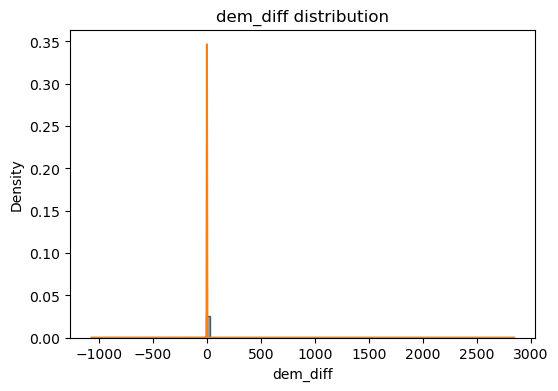

In [20]:
# histogram + density
vals = pd.Series(grid.at_node["dem_diff"]).replace(-9999, pd.NA).dropna()

plt.figure(figsize=(6,4))
plt.hist(vals, bins=50, density=True, alpha=0.6, edgecolor="k")
vals.plot(kind="kde")
plt.title("dem_diff distribution")
plt.xlabel("dem_diff")
plt.ylabel("Density")
plt.show()


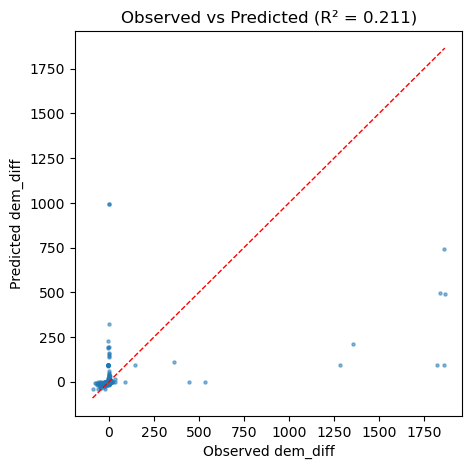

In [24]:
r2 = r2_score(y_test, pred)

plt.figure(figsize=(5,5))
plt.scatter(y_test, pred, s=5, alpha=0.5)
plt.xlabel("Observed dem_diff")
plt.ylabel("Predicted dem_diff")
plt.title(f"Observed vs Predicted (R² = {r2:.3f})")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", linewidth=1)
plt.show()

In [28]:
# predict for all nodes
X_all = pd.DataFrame({v: grid.at_node[v] for v in vars_of_interest if v != "dem_diff"})
X_all = X_all.replace(-9999, np.nan).fillna(0)  # simple fill

pred_all = rf.predict(X_all)
grid.add_field("dem_diff_pred", pred_all, at="node", clobber=True)


array([-0.10852634, -0.10852634, -0.10852634, ..., -0.10852634,
       -0.10852634, -0.10852634], shape=(1006824,))

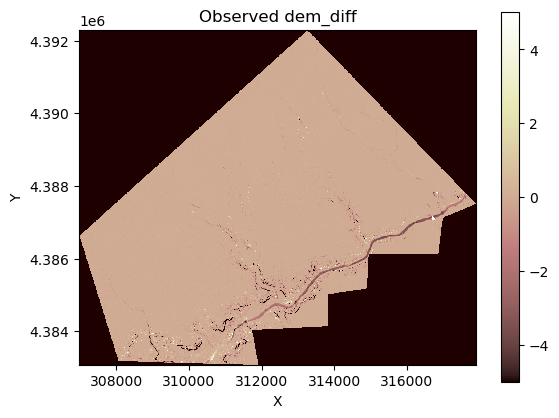

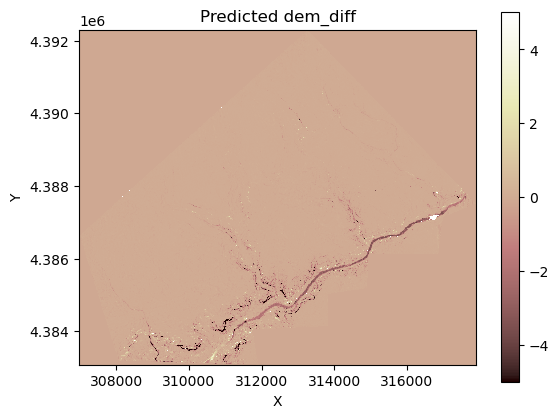

In [39]:
vmin = -5
vmax = 5

plt.figure()
imshow_grid(grid, "dem_diff", plot_name="Observed dem_diff", limits=(vmin, vmax))
plt.show()

plt.figure()
imshow_grid(grid, "dem_diff_pred", plot_name="Predicted dem_diff", limits=(vmin, vmax))
plt.show()

In [30]:
train_pred = rf.predict(X_train)
test_pred  = rf.predict(X_test)

train_r2 = r2_score(y_train, train_pred)
test_r2  = r2_score(y_test, test_pred)

print("Train R2:", train_r2)
print("Test R2:", test_r2)


Train R2: 0.878628651711292
Test R2: 0.21107814677338577


In [43]:
from pathlib import Path
import numpy as np
import pyproj

out_dir = Path("/mnt/c/Users/amehedi/Downloads/ml_debris/output")
out_asc = out_dir / "dem_diff_pred.asc"
out_prj = out_dir / "dem_diff_pred.prj"

# REQUIRED: set these from your grid/known values
nrows, ncols = grid.shape  # works if grid has shape
cellsize = 10  # meters (from your layer info)

# REQUIRED: set lower-left corner (xll, yll) in EPSG:32613
# Put the correct values here (from your existing layer info)
xll = 306982.9351981145
yll = 4392303.264309346

data = np.asarray(grid.at_node["dem_diff_pred"]).reshape(nrows, ncols)

with open(out_asc, "w") as f:
    f.write(f"ncols         {ncols}\n")
    f.write(f"nrows         {nrows}\n")
    f.write(f"xllcorner     {xll}\n")
    f.write(f"yllcorner     {yll}\n")
    f.write(f"cellsize      {cellsize}\n")
    f.write(f"NODATA_value  -9999\n")
    for row in data:
        f.write(" ".join(map(str, row)) + "\n")

# write .prj
crs = pyproj.CRS.from_epsg(32613)
out_prj.write_text(crs.to_wkt())

print("Saved:", out_asc, out_prj)


Saved: /mnt/c/Users/amehedi/Downloads/ml_debris/output/dem_diff_pred.asc /mnt/c/Users/amehedi/Downloads/ml_debris/output/dem_diff_pred.prj


In [ ]:
import geopandas as gpd
import pandas as pd
from pathlib import Path
import requests

# AOI
aoi_path = "/mnt/c/Users/amehedi/Downloads/ml_debris/input/atl2017_perim_feat.shp"
aoi = gpd.read_file(aoi_path).to_crs(4326)

# USGS WESM GeoPackage (spatial metadata)
wesm_url = "https://rockyweb.usgs.gov/vdelivery/Datasets/Staged/Elevation/metadata/WESM.gpkg"
wesm_path = Path("/tmp/WESM.gpkg")

if not wesm_path.exists():
    r = requests.get(wesm_url, stream=True, timeout=60)
    r.raise_for_status()
    with open(wesm_path, "wb") as f:
        for chunk in r.iter_content(1024 * 1024):
            if chunk:
                f.write(chunk)

wesm = gpd.read_file(wesm_path)

# ensure CRS
if wesm.crs is None:
    wesm = wesm.set_crs(4326)
wesm = wesm.to_crs(aoi.crs)

# spatial filter
aoi_union = aoi.unary_union
wesm_aoi = wesm[wesm.intersects(aoi_union)].copy()

# parse acquisition dates
for c in ["collect_start", "collect_end"]:
    if c in wesm_aoi.columns:
        wesm_aoi[c] = pd.to_datetime(wesm_aoi[c], errors="coerce")

# show acquisition dates by work unit
cols = [c for c in ["workunit", "workunit_id", "collect_start", "collect_end"] if c in wesm_aoi.columns]
wesm_aoi[cols].sort_values(["collect_start", "collect_end"])

In [ ]:
import geopandas as gpd
import pandas as pd
import requests
import xml.etree.ElementTree as ET
from pathlib import Path
from urllib.parse import urlparse, parse_qs

# --- WESM ---
wesm_url = "https://rockyweb.usgs.gov/vdelivery/Datasets/Staged/Elevation/metadata/WESM.gpkg"
wesm_path = Path("/tmp/WESM.gpkg")
if not wesm_path.exists():
    r = requests.get(wesm_url, stream=True, timeout=60)
    r.raise_for_status()
    with open(wesm_path, "wb") as f:
        for chunk in r.iter_content(1024 * 1024):
            if chunk:
                f.write(chunk)

wesm = gpd.read_file(wesm_path)

# pick the two workunit IDs you want
targets = {
    177292: "dem_pre",   # CA_NoCAL_Wildfires_B5b_2018
    300636: "dem_post",  # CA_NorthCoastRanges_2_B23
}

sel = wesm[wesm["workunit_id"].isin(targets.keys())].copy()
sel[["workunit","workunit_id","collect_start","collect_end","sourcedem_link"]]

In [ ]:
import geopandas as gpd
import rasterio
from rasterio.warp import transform_bounds
from shapely.geometry import box
from pathlib import Path
import requests
import xml.etree.ElementTree as ET
from urllib.parse import urlparse, parse_qs

# --- AOI ---
aoi = gpd.read_file("/mnt/c/Users/amehedi/Downloads/ml_debris/input/atl2017_perim_feat.shp").to_crs(4326)
aoi_bounds = aoi.total_bounds  # (minx, miny, maxx, maxy)

def intersects_aoi(url, aoi_bounds_wgs84):
    # read header only (fast), no full download
    with rasterio.Env(AWS_NO_SIGN_REQUEST="YES"):
        with rasterio.open(f"/vsicurl/{url}") as src:
            aoi_in_tile = transform_bounds("EPSG:4326", src.crs, *aoi_bounds_wgs84, densify_pts=21)
            return box(*aoi_in_tile).intersects(box(*src.bounds))

def s3_list_tifs_from_sourcedem_link(sourcedem_link):
    if not sourcedem_link:
        return []
    qs = parse_qs(urlparse(sourcedem_link).query)
    prefix = qs.get("prefix", [None])[0]
    if not prefix:
        return []
    prefix = prefix.strip("/") + "/"

    base = "https://prd-tnm.s3.amazonaws.com"
    urls = []
    token = None

    while True:
        params = {"list-type": "2", "prefix": prefix}
        if token:
            params["continuation-token"] = token

        r = requests.get(base, params=params, timeout=60)
        r.raise_for_status()
        root = ET.fromstring(r.text)
        ns = {"s3": "http://s3.amazonaws.com/doc/2006-03-01/"}

        for k in root.findall("s3:Contents/s3:Key", ns):
            key = k.text
            if key.lower().endswith(".tif"):
                urls.append(f"{base}/{key}")

        token_el = root.find("s3:NextContinuationToken", ns)
        if token_el is None or not token_el.text:
            break
        token = token_el.text

    return urls

out_dir = Path("/mnt/c/Users/amehedi/Downloads/ml_debris/output")
dem_src_dir = out_dir / "dem_source_tiles"
dem_src_dir.mkdir(exist_ok=True)

workunit_tifs = {}
for _, row in sel.iterrows():
    name = targets[row["workunit_id"]]

    # list all tiles in the work unit
    urls = s3_list_tifs_from_sourcedem_link(row.get("sourcedem_link"))
    if not urls:
        print("No source DEM link for", row["workunit_id"])
        continue

    # filter to AOI
    urls = [u for u in urls if intersects_aoi(u, aoi_bounds)]
    print(name, "tiles:", len(urls))

    paths = []
    for url in urls:
        local = dem_src_dir / Path(url).name
        if not local.exists():
            r = requests.get(url, stream=True, timeout=60)
            r.raise_for_status()
            with open(local, "wb") as f:
                for chunk in r.iter_content(1024 * 1024):
                    if chunk:
                        f.write(chunk)
        paths.append(local)

    workunit_tifs[name] = paths 

In [ ]:
import rasterio
from rasterio.merge import merge
from landlab.io import esri_ascii

# use your existing helper functions:
# reproject_raster_to_match_crs, resample_raster, clip_raster_to_shape, convert_to_ascii

clip_shapefile = "/mnt/c/Users/amehedi/Downloads/ml_debris/input/grz2020_perim_feat.shp"
target_resolution = 10

# template_meta from your topographic__elevation.asc
with rasterio.open(out_dir / "topographic__elevation.asc") as src:
    template_meta = src.meta.copy()

def mosaic_tifs(tif_list, out_path):
    srcs = [rasterio.open(p) for p in tif_list]
    mosaic, transform = merge(srcs)
    meta = srcs[0].meta.copy()
    meta.update({
        "height": mosaic.shape[1],
        "width": mosaic.shape[2],
        "transform": transform
    })
    with rasterio.open(out_path, "w", **meta) as dst:
        dst.write(mosaic)
    for s in srcs:
        s.close()
    return out_path

def make_dem_field(src_tif, field_name):
    reproj = reproject_raster_to_match_crs(
        str(src_tif), target_crs_epsg=template_meta["crs"].to_epsg(),
        resampling_method="cubic", template_meta=template_meta
    )
    resamp = resample_raster(
        reproj, template_meta=template_meta,
        resampling_method="cubic", target_resolution=target_resolution
    )
    clipped = clip_raster_to_shape(resamp, clip_shapefile, template_meta=template_meta)
    asc = convert_to_ascii(clipped, out_dir, template_meta=template_meta)

    with open(asc, "r") as f:
        tmp = esri_ascii.load(f, name=field_name)

    grid.add_field(field_name, tmp.at_node[field_name], at="node", clobber=True)
    return grid.at_node[field_name]

dem_pre_tif  = mosaic_tifs(workunit_tifs["dem_pre"],  out_dir / "dem_pre_mosaic.tif")
dem_post_tif = mosaic_tifs(workunit_tifs["dem_post"], out_dir / "dem_post_mosaic.tif")

dem_pre  = make_dem_field(dem_pre_tif,  "dem_pre")
dem_post = make_dem_field(dem_post_tif, "dem_post")

In [ ]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import json

def filter_urls_parallel(urls, aoi_geom, max_workers=32):
    keep = []
    with ThreadPoolExecutor(max_workers=max_workers) as ex:
        futs = {ex.submit(intersects_aoi_geom, u, aoi_geom): u for u in urls}
        for i, fut in enumerate(as_completed(futs), 1):
            u = futs[fut]
            try:
                if fut.result():
                    keep.append(u)
            except Exception:
                pass
            if i % 200 == 0:
                print(f"checked {i}/{len(urls)}")
    return keep

for _, row in sel.iterrows():
    name = targets[row["workunit_id"]]
    urls = s3_list_tifs_from_sourcedem_link(row.get("sourcedem_link"))

    # cache filtered list
    cache_file = out_dir / f"{name}_filtered_urls.json"
    if cache_file.exists():
        urls = json.loads(cache_file.read_text())
    else:
        urls = filter_urls_parallel(urls, aoi_geom, max_workers=32)
        cache_file.write_text(json.dumps(urls))

    print(name, "tiles after filter:", len(urls))

In [ ]:
import json
import geopandas as gpd
import rasterio
from rasterio.warp import transform_bounds
from rasterio.crs import CRS
import subprocess
from pathlib import Path
import shutil

# paths
aoi_path = "/mnt/c/Users/amehedi/Downloads/ml_debris/input/atl2017_perim_feat.shp"
out_dir = Path("/mnt/c/Users/amehedi/Downloads/ml_debris/output")

# AOI + CRS (fix: set template_crs from AOI)
aoi = gpd.read_file(aoi_path).to_crs(4326)
aoi_bounds_wgs84 = aoi.total_bounds

centroid = aoi.geometry.union_all().centroid
zone = int((centroid.x + 180) / 6) + 1
epsg = 32600 + zone  # northern hemisphere
template_crs = CRS.from_epsg(epsg)

# template bounds/res from the ASCII grid
with rasterio.open(out_dir / "topographic__elevation.asc") as src:
    template_bounds = src.bounds
    template_res = src.res

for name in ["dem_pre", "dem_post"]:
    urls = json.loads((out_dir / f"{name}_filtered_urls.json").read_text())

    # list file in WSL path
    list_file = Path("/tmp") / f"{name}_urls.txt"
    list_file.write_text("\n".join([f"/vsicurl/{u}" for u in urls]))

    # output in WSL path
    out_tif_wsl = Path("/tmp") / f"{name}.tif"

    bbox_in_dem = transform_bounds("EPSG:4326", template_crs, *aoi_bounds_wgs84, densify_pts=21)

    subprocess.run([
        "gdalwarp",
        "-t_srs", template_crs.to_string(),
        "-tr", str(template_res[0]), str(template_res[1]),
        "-tap",
        "-te", str(bbox_in_dem[0]), str(bbox_in_dem[1]),
              str(bbox_in_dem[2]), str(bbox_in_dem[3]),
        "-r", "bilinear",
        "-of", "GTiff",
        "-multi", "-wo", "NUM_THREADS=ALL_CPUS",
        f"@{list_file}",
        str(out_tif_wsl),
    ], check=True)

    # copy to Windows output dir
    out_tif = out_dir / f"{name}.tif"
    shutil.copy(out_tif_wsl, out_tif)

    with rasterio.open(out_tif) as src:
        arr = src.read(1)
        grid.add_field(name, arr.reshape(-1), at="node", clobber=True)

# dem_pre  = grid.at_node["dem_pre"]
# dem_post = grid.at_node["dem_post"]


In [ ]:
from pathlib import Path

list_file = Path("/tmp") / f"{name}_urls.txt"
list_file.write_text("\n".join([f"/vsicurl/{u}" for u in urls]))

print("list file exists:", list_file.exists(), list_file)

In [ ]:
import shutil
import subprocess
from pathlib import Path

gdalwarp_path = shutil.which("gdalwarp")
print("gdalwarp:", gdalwarp_path)

for name in ["dem_pre", "dem_post"]:
    urls = json.loads((out_dir / f"{name}_filtered_urls.json").read_text())

    if gdalwarp_path and gdalwarp_path.lower().endswith(".exe"):
        # Windows gdalwarp -> use Windows path
        list_file = out_dir / f"{name}_urls.txt"
        list_file.write_text("\n".join([f"/vsicurl/{u}" for u in urls]))
        list_file_arg = "@" + subprocess.check_output(["wslpath", "-w", str(list_file)]).decode().strip()
        out_tif = out_dir / f"{name}.tif"
        out_tif_arg = subprocess.check_output(["wslpath", "-w", str(out_tif)]).decode().strip()
    else:
        # WSL gdalwarp -> use WSL path
        list_file = Path("/tmp") / f"{name}_urls.txt"
        list_file.write_text("\n".join([f"/vsicurl/{u}" for u in urls]))
        list_file_arg = f"@{list_file}"
        out_tif = Path("/tmp") / f"{name}.tif"
        out_tif_arg = str(out_tif)

    bbox_in_dem = transform_bounds("EPSG:4326", template_crs, *aoi_bounds_wgs84, densify_pts=21)

    subprocess.run([
        "gdalwarp",
        "-t_srs", template_crs.to_string(),
        "-tr", str(template_res[0]), str(template_res[1]),
        "-tap",
        "-te", str(bbox_in_dem[0]), str(bbox_in_dem[1]),
              str(bbox_in_dem[2]), str(bbox_in_dem[3]),
        "-r", "bilinear",
        "-of", "GTiff",
        "-multi", "-wo", "NUM_THREADS=ALL_CPUS",
        list_file_arg,
        out_tif_arg,
    ], check=True)

    # if WSL output, copy back
    if not str(out_tif).startswith(str(out_dir)):
        shutil.copy(out_tif, out_dir / f"{name}.tif")

    with rasterio.open(out_dir / f"{name}.tif") as src:
        arr = src.read(1)
        grid.add_field(name, arr.reshape(-1), at="node", clobber=True)

In [ ]:
list_file = Path("/home/abdullah") / f"{name}_urls.txt"


In [ ]:
print(name, "tiles after filter:", len(urls))

In [ ]:
u = urls[0]
with rasterio.Env(AWS_NO_SIGN_REQUEST="YES"):
    with rasterio.open(f"/vsicurl/{u}") as src:
        print("CRS:", src.crs)
        print("Bounds:", src.bounds)
        print("Resolution:", src.res)
        print("Size (pixels):", src.width, src.height)


In [ ]:
import geopandas as gpd
from shapely.geometry import box

aoi = gpd.read_file(aoi_path).to_crs(4326)
aoi_area_km2 = aoi.to_crs(32610).area.sum() / 1e6  # pick your UTM
print("AOI area (km^2):", aoi_area_km2)


In [ ]:
print(name, "tiles after filter:", len(urls))

In [ ]:
aoi = gpd.read_file(aoi_path).to_crs(4326)
print(aoi.total_bounds)